In [1]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

# Load the JSON dataset into a pandas DataFrame
try:
    df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Sarcasm_Headlines_Dataset.json not found. Please make sure the file is in the correct directory.")
    df = None

# If the dataset was loaded successfully, let's explore the first few rows
if df is not None:
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    # Let's also get some basic information about the dataset
    print("\nInformation about the dataset:")
    print(df.info())

    # And check the distribution of the target variable
    print("\nDistribution of sarcastic vs. non-sarcastic headlines:")
    print(df['is_sarcastic'].value_counts())

Dataset loaded successfully!

First 5 rows of the dataset:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ---

In [7]:
# Drop the 'article_link' column
df = df.drop('article_link', axis=1)

# Let's check the first 5 rows again to confirm the column is dropped
print("\nFirst 5 rows after dropping 'article_link':")
print(df.head())

# Let's also check the DataFrame info to see the updated columns
print("\nInformation about the dataset after dropping 'article_link':")
print(df.info())


First 5 rows after dropping 'article_link':
   is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails why congress is falling...
2             0  eat your veggies: 9 deliciously different recipes
3             1  inclement weather prevents liar from getting t...
4             1  mother comes pretty close to using word 'strea...

Information about the dataset after dropping 'article_link':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB
None



Descriptive statistics of headline lengths:
count    28619.000000
mean        10.049967
std          3.388307
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: headline_length, dtype: float64


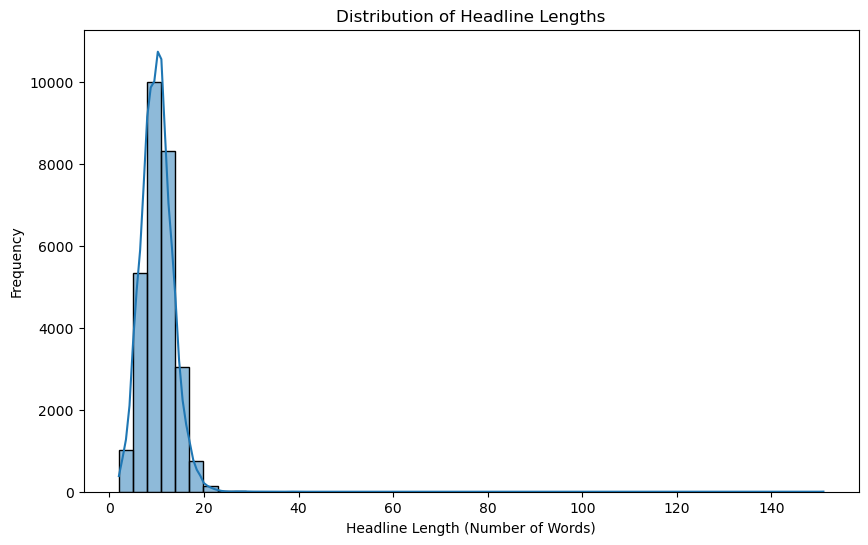

In [9]:
# Get the length of each headline (number of words)
headline_lengths = df['headline'].apply(lambda x: len(x.split()))

# Add the headline lengths as a new column to the DataFrame (optional, but can be useful)
df['headline_length'] = headline_lengths

# Display some descriptive statistics of the headline lengths
print("\nDescriptive statistics of headline lengths:")
print(df['headline_length'].describe())

# You can also visualize the distribution using a histogram (optional, requires matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=50, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Calculate the 95th percentile of headline lengths
percentile_95 = df['headline_length'].quantile(0.95)
print(f"\n95th percentile of headline lengths: {percentile_95}")


95th percentile of headline lengths: 16.0


In [25]:
# Define parameters
MAX_SEQUENCE_LENGTH = 20  # We'll pad/truncate headlines to this length. Slightly higher than 95th percentile to be safe.
EMBEDDING_DIM = 50    # Dimensionality of the GloVe word embeddings we'll use.
OOV_TOKEN = "<OOV>"       # Token for out-of-vocabulary words.
TRUNCATING = 'post'       # Truncate sequences at the end.
PADDING = 'post'          # Pad sequences at the end.
TEST_SIZE = 0.2           # Fraction of data to use for testing (we'll split later).
RANDOM_STATE = 42         # For reproducibility.
BATCH_SIZE = 32           # Number of samples per training batch.
NUM_EPOCHS = 10           # Number of training epochs (we can adjust this).

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the Tokenizer
tokenizer = Tokenizer(oov_token=OOV_TOKEN)

# Fit the tokenizer on our headlines
tokenizer.fit_on_texts(df['headline'])

# Get the word index (vocabulary)
word_index = tokenizer.word_index

print("First 20 items in the word index:")
for item in list(word_index.items())[:20]:
    print(f"{item[0]:<15} : {item[1]}")

First 20 items in the word index:
<OOV>           : 1
to              : 2
of              : 3
the             : 4
in              : 5
for             : 6
a               : 7
on              : 8
and             : 9
with            : 10
is              : 11
new             : 12
trump           : 13
man             : 14
at              : 15
from            : 16
about           : 17
by              : 18
after           : 19
you             : 20


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Convert text headlines to sequences of indices
sequences = tokenizer.texts_to_sequences(df['headline'])

# Pad sequences to the defined MAX_SEQUENCE_LENGTH
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding=PADDING, truncating=TRUNCATING)

# Get the labels
labels = np.array(df['is_sarcastic'])

# Split the data into training and testing sets
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    padded_sequences, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("Shape of training sequences:", train_sequences.shape)
print("Shape of testing sequences:", test_sequences.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing labels:", test_labels.shape)

print("\nExample of a padded sequence:")
print(train_sequences[0])
print("\nCorresponding label:")
print(train_labels[0])

Shape of training sequences: (22895, 20)
Shape of testing sequences: (5724, 20)
Shape of training labels: (22895,)
Shape of testing labels: (5724,)

Example of a padded sequence:
[  28   13  110  716   17  843   67 4950    5   43 1742    0    0    0
    0    0    0    0    0    0]

Corresponding label:
0


In [33]:
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 because the indices start from 1

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 30886


In [35]:
# Path to the GloVe embeddings file
GLOVE_FILE_PATH = 'D:\\Second Sem Subjects\\NLP\\NLPA_LLT_25\\glove.6B.50d.txt'

# Initialize an empty dictionary to store word embeddings
embeddings_index = {}

try:
    with open(GLOVE_FILE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
except FileNotFoundError:
    print(f"Error: GloVe embeddings file not found at {GLOVE_FILE_PATH}. Please download it and ensure the path is correct.")
    embeddings_index = None

if embeddings_index is not None:
    # Create an embedding matrix for our vocabulary
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    print(f"\nShape of the embedding matrix: {embedding_matrix.shape}")

Loaded 400000 word vectors from GloVe.

Shape of the embedding matrix: (30886, 50)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Define the model
model = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,544,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,544,300 (5.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,544,300 (5.89 MB)

In [39]:
# Create a validation set from the training data
train_sequences_subset, val_sequences, train_labels_subset, val_labels = train_test_split(
    train_sequences, train_labels, test_size=0.1, random_state=RANDOM_STATE
)

# Fit the model
history = model.fit(
    train_sequences_subset,
    train_labels_subset,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_sequences, val_labels),
    verbose=1
)

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - accuracy: 0.7046 - loss: 0.5621 - val_accuracy: 0.8017 - val_loss: 0.4259
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8262 - loss: 0.3859 - val_accuracy: 0.8245 - val_loss: 0.3836
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8534 - loss: 0.3307 - val_accuracy: 0.8349 - val_loss: 0.3610
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8720 - loss: 0.2940 - val_accuracy: 0.8520 - val_loss: 0.3537
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.8883 - loss: 0.2589 - val_accuracy: 0.8467 - val_loss: 0.3598
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.9050 - loss: 0.2226 - val_accuracy: 0.8463 - val_loss: 0.3686
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.9231 - loss: 0.1892 - val_accuracy: 0.8463 - val_loss: 0.3790
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.9420 - loss: 0.1477 - 

In [41]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_sequences, test_labels, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.4934
Test Accuracy: 0.8489


In [45]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming you have already created 'padded_sequences' and 'labels'

# Split the data into training and testing sets, also getting the indices
train_sequences, test_sequences, train_labels, test_labels, train_indices, test_indices = train_test_split(
    padded_sequences, labels, df.index, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Make predictions on the test set
predictions = model.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions = np.round(predictions).flatten().astype(int)

# Create a DataFrame to easily compare predictions with original headlines
results_df = pd.DataFrame({'headline': df['headline'].iloc[test_indices].values,  # Get original headlines using the indices
                           'actual_sarcastic': test_labels,
                           'predicted_sarcastic': binary_predictions})

print("\nFirst 20 Predicted vs. Actual Headlines:")
print(results_df.head(20))

179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step

First 20 Predicted vs. Actual Headlines:
                                             headline  actual_sarcastic  \
0   states slow to shut down weak teacher educatio...                 0   
1     drone places fresh kill on steps of white house                 1   
2   report: majority of instances of people gettin...                 1   
3   sole remaining lung filled with rich, satisfyi...                 1   
4                        the gop's stockholm syndrome                 0   
5                                   trump's game plan                 0   
6   lea michele romances fake gosling in 'on my wa...                 0   
7    report: that whole side of family just like that                 1   
8   new extended paternity leave offers dads more ...                 1   
9   nation hopeful there will be equally random ch...                 1   
10  sean spicer finally calls it quits after 6 mon...                 0   
11  band targete

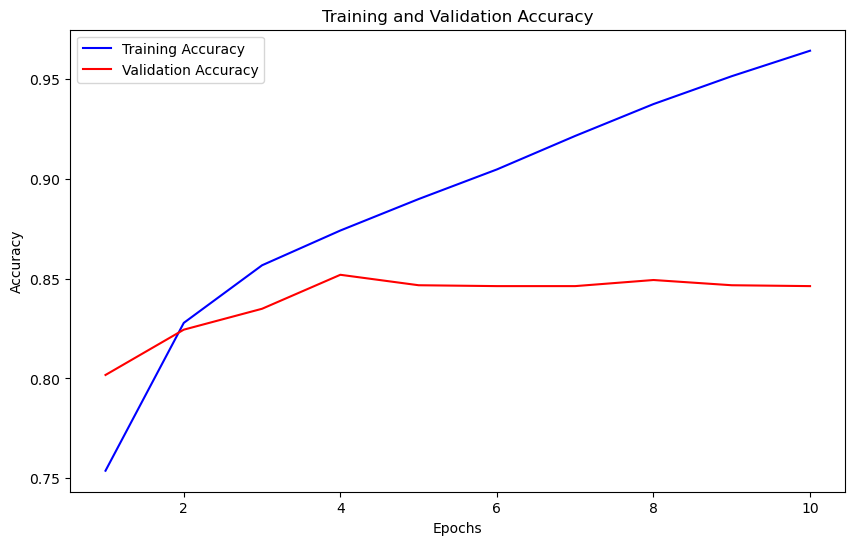

In [47]:
import matplotlib.pyplot as plt

# Get the training accuracy and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, binary_predictions))



Confusion Matrix:
[[2492  503]
 [ 362 2367]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2995
           1       0.82      0.87      0.85      2729

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724

